# **Homework 4: Linear Predictors**


In this homework, you will explore **linear prediction models** and apply different algorithms to solve a binary classification problem on the **Spam dataset**. You will implement key components of linear models, such as **least squares regression**, the **perceptron algorithm**, and **linear programming with hinge loss**, while learning how each method works.

There are a number of programming **tasks** and **quiz questions** in this homework.
- For **tasks**, you will need to either **add code between comments "`#### TASK N CODE`"** to complete them or **modify code between those comments**. **DO NOT delete the comments "#### TASK N CODE". This is for graders' reference and you might not get full points if you tamper with these comments.**
- For **quiz questions**, you will need to answer in a few sentences between the given lines.
- For **optional tasks**, you are **NOT required to turn them in**. However, we encourage you to complete them as they are good practice.
- For **challenge-optional tasks**, you are **NOT required to turn them in**. However, you will receive extra credit for completing the challenge.


## Preparation

We will keep using spam dataset in this homework and use the same feature map `SMS_Vectorizer` in homework 3 to convert messages into vector representations. 

In [2]:
# !pip install gdown
# !gdown 1LVIPm9filzd6Z3h1QMIPzUUiiw8TQ2Zu

!mkdir data
!wget  -O data/SMSSpamCollection https://www.dropbox.com/scl/fi/mdobhv2gwvvswe9ujtn7v/SMSSpamCollection?rlkey=80xp0dzb70tthuvuv9fuda0fk

--2025-01-27 19:58:42--  https://www.dropbox.com/scl/fi/mdobhv2gwvvswe9ujtn7v/SMSSpamCollection?rlkey=80xp0dzb70tthuvuv9fuda0fk
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6018:18::a27d:312, 162.125.3.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6018:18::a27d:312|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6e29d7b5842ce8ec75744cd212.dl.dropboxusercontent.com/cd/0/inline/CjDYbGskhlNqpN216PAdMq4qz4GfAlFYBc90u6RGwWmGu1Ecwc82bHEU817J_QS60fUw2RGQeJzRxFNXnKEH8yA88a2Wnl2x6u5U50EovRfPYEOITQ7LeKkzQYBVD26gvXG41mmAh0nx3XJAV6sbFQ1G/file# [following]
--2025-01-27 19:58:44--  https://uc6e29d7b5842ce8ec75744cd212.dl.dropboxusercontent.com/cd/0/inline/CjDYbGskhlNqpN216PAdMq4qz4GfAlFYBc90u6RGwWmGu1Ecwc82bHEU817J_QS60fUw2RGQeJzRxFNXnKEH8yA88a2Wnl2x6u5U50EovRfPYEOITQ7LeKkzQYBVD26gvXG41mmAh0nx3XJAV6sbFQ1G/file
Resolving uc6e29d7b5842ce8ec75744cd212.dl.dropboxusercontent.com (uc6e29d7b5842ce8ec75744cd212.dl.dropboxusercontent.com)... 2

In [1]:
from typing import Dict, List, Optional, Tuple
import os
import numpy as np
import matplotlib.pyplot as plt
import utils_hw4
from utils_hw4 import TrainAndTestData, report_losses, generate_linear_separable_data, create_split

seed = 0
np.random.seed(seed)

c:\Users\matth\OneDrive\Documents\School\Senior Year\Winter Quarter\TTIC 31020\hw4\utils_hw4.py:93: SyntaxWarning: invalid escape sequence '\w'
  data['text'] = data['text'].str.replace('[^\w\s]', '', regex=True)


In [2]:
class SMS_Vectorizer:
    def __init__(self, sentences, d):
        # Count the total occurrences of each word in sentences
        word_freq = {}
        for sentence in sentences:
            for word in sentence.lower().split():
                if word not in word_freq:
                    word_freq[word] = 1
                else:
                    word_freq[word] += 1

        # Save the d words with the highest frequency
        self.high_freq_words = sorted([(word_freq[word], word) for word in word_freq], reverse=True)[: d]
        self.high_freq_words = [item[1] for item in self.high_freq_words]

    def vectorize(self, sentences):
        # vector[i][j]: how many occurrences of self.high_freq_words[j] we find in sentences[i]
        vectors = np.zeros((len(sentences), len(self.high_freq_words)))
        for i, sentence in enumerate(sentences):
            sentence = sentence.lower().split()
            for j, word in enumerate(self.high_freq_words):
                vectors[i][j] = sentence.count(word)
        return np.array(vectors)


Xr, yr = utils_hw4.read_sms_spam_data(os.path.join(os.getcwd(), 'data/SMSSpamCollection'))
spamdata = TrainAndTestData(*utils_hw4.create_split(Xr, yr, 0.7))
Vectorizer = SMS_Vectorizer(spamdata.X_train, d=100)
vectorized_data = TrainAndTestData(Vectorizer.vectorize(spamdata.X_train), spamdata.y_train, Vectorizer.vectorize(spamdata.X_test), spamdata.y_test)

We first define `LinearClassifier` as an abstract class that can only be subclassed. We can build on top of this to get the various different classifiers we will eventually be interested in, and this keeps us from having to implement reusable functions like `predict` and `error` over and over.

In [4]:
class Classifier:
    def error(self,X,y):
        """Error rate (empirical 0/1 error on the give data)"""
        return np.mean(self.predict(X)!=y)

def homogeneous_phi(x):
    return x

class LinearClassifier(Classifier):
    """A based class for linear classifiers.

    Uses the weight vector self.w, but this base class does not define self.w.
    It needs to be defined (e.g. learned from data) in a subclass."""
    def __init__(self,phi=homogeneous_phi):
        self.phi=phi
        
    def predict_value(self,X):
        return self.phi(X)@self.w
    
    def predict(self,X):
        return np.sign(self.predict_value(X))
    
    def hinge_loss(self,X,y):
        hinge_loss = np.mean(np.maximum(0, 1 - y * self.predict_value(X)))
        return hinge_loss
    
    def squared_loss(self, X, y):
        squared_loss = np.mean((self.predict_value(X) - y) ** 2)
        return squared_loss  

### [Task 1]: Minimizing Square Loss

In this task, you need to finish the linear regression function below that returns the solution of minimizing square loss $\sum_{i} (h_w(\phi(x_i))-y_i)^2$. 

Here, we treat the labels $y_i$ as real values, even though they represent discrete classes (+1 or -1). This is a common approach in machine learning because minimizing the squared loss is computationally simple and leads to a closed-form solution. While this approach does not directly optimize for classification accuracy, it can be used as a baseline to fit linear models, which we will compare with other methods later. 

In [6]:
# Subclass for Linear Regression
class LinearRegressionClassifier(LinearClassifier):
    def fit(self, X, y):
        """Fit using least-squares linear regression."""
        #### TASK 1 code
        # You should compute $w$ by yourself instead of calling any external linear regression function. 
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y
        #### TASK 1 code

spam_lr_clf = LinearRegressionClassifier()
spam_lr_clf.fit(vectorized_data.X_train, vectorized_data.y_train)

report_losses(spam_lr_clf, vectorized_data.X_train, vectorized_data.y_train, vectorized_data.X_test, vectorized_data.y_test)

Training error (0-1 loss): 0.0954
Test error (0-1 loss): 0.0995
Training hinge loss: 0.5197
Test hinge loss: 0.5121
Training squared loss: 0.4572
Test squared loss: 0.4829


### [Task 2]: Perceptron Algorithm

Now we want to implement the perceptron algorithm we learned in lecture 5. As mentioned in the written homework, it is inefficient to compute labels for the whole training set at each step in order to check whether there is an error. Instead, we can do it in a cyclic way. At each epoch, we will iterate over the whole training dataset in the fixed order and update the parameters when we make a mistake. Stop the iteration when the classifier doesn't make any mistake on the training set. 

There are also other approaches and you are welcome to try them. Each of these approaches can have different converged solutions. 
- **Fixed-order iteration with restart.** Iterate over the training dataset in the fixed order. Once we make a mistake, we will update the parameters and restart the iteration from the beginning. 
- **Shuffled iteration.** At each epoch, shuffle the training dataset and iterate over the whole training dataset in the new order. Update the parameters when we make a mistake. 
- **Random sampling.** At each step, sample a training data points with replacement. Update the parameter if we make a mistake. 

In [7]:
# Subclass for Perceptron
class PerceptronClassifier(LinearClassifier):
    def fit(self, X, y, X_test=None, y_test=None, track_errors=True):
        """Fit using the Perceptron algorithm."""
        self.w = np.zeros(self.phi(X).shape[1]) # initialize the weight vector as zeros
        self.finished_epochs = 0
        self.train_errors=[] # store the training error after each update

        if X_test is not None and y_test is not None:
            self.test_errors = [] # store the test error after each update
        while True:
            errors = 0
            for i in range(len(X)):
                #### TASK 2 CODE
                if np.sign(self.w.T @ self.phi(X[i])) != y[i]: # update condition
                    self.w = self.w + y[i] * self.phi(X[i]) # update the weight vector
                #### TASK 2 CODE
                    errors += 1

                    if track_errors:
                        # Even though here we keep track of the training and test errors after each update, it is not necessary for the algorithm.
                        # It is just for you to see how the errors change after each update.
                        self.train_errors.append(self.error(X, y))
                        if X_test is not None and y_test is not None:
                            self.test_errors.append(self.error(X_test, y_test))
            self.finished_epochs += 1
            if self.stopping_criterion(errors):
                break
    
    def stopping_criterion(self, errors):
        return errors == 0

    def compute_num_errors(self):
        return len(self.train_errors) - 1
    
    def get_error_traces(self):
        """
        Returns the training and test error traces for plotting.
        """
        if len(self.train_errors) == 0:
            raise ValueError("Train errors are not logged.")
        else:
            return self.train_errors, self.test_errors

We will first run perceptron algorithm on some linear separable data. Below we show the example with dimension 2. But you will run experiments on data with dimension 10. 

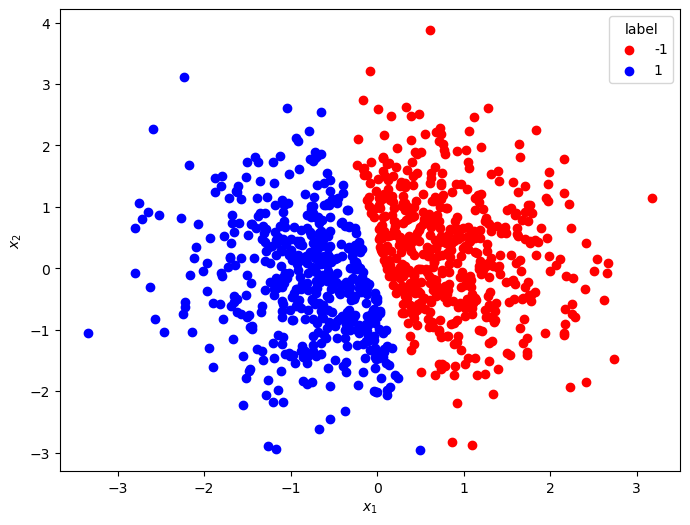

In [8]:
X, y = generate_linear_separable_data(n_samples=1000, n_features=2, margin=0.1)
utils_hw4.scatter_plot(X, y)  

Margin: 0.1
Number of errors: 117


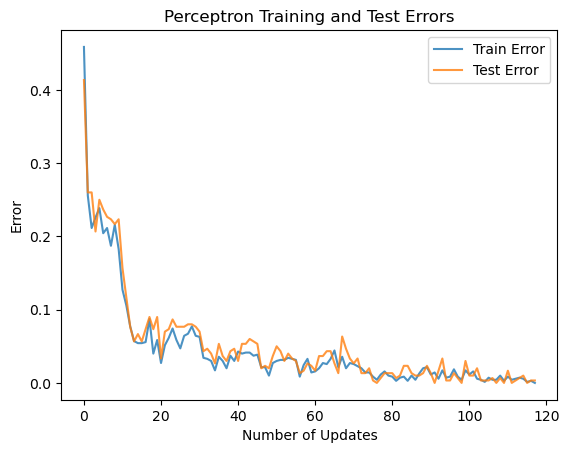

In [20]:
# run perceptron on 10-d data
margin = 0.1
X, y = generate_linear_separable_data(n_samples=1000, n_features=10, margin=margin)

# Split into training and test sets (70-30 split)
X_train, y_train, X_test, y_test = create_split(X, y, split_ratio=0.7)

linear_perceptron_clf = PerceptronClassifier()
linear_perceptron_clf.fit(X_train, y_train, X_test, y_test)

print('Margin:', margin)
print('Number of errors:', linear_perceptron_clf.compute_num_errors())

train_errors, test_errors = linear_perceptron_clf.get_error_traces()
utils_hw4.plot_errors(train_errors, test_errors)

<span style="color: red">
<h4 style="font-weight: bold">[Answer Questions]</h4>

Please try different values of the margin. How does the number of errors behave with different margin values?<br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: The number of errors seems to be inversely related to the margin. When the margin is very small, 0.01, the number of errors was 1724. When the margin was 0.05, the number of errors was 202. When the margin was 0.1, 117.
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

Next we will run perceptron on the spiral data that we saw in homework 3. 

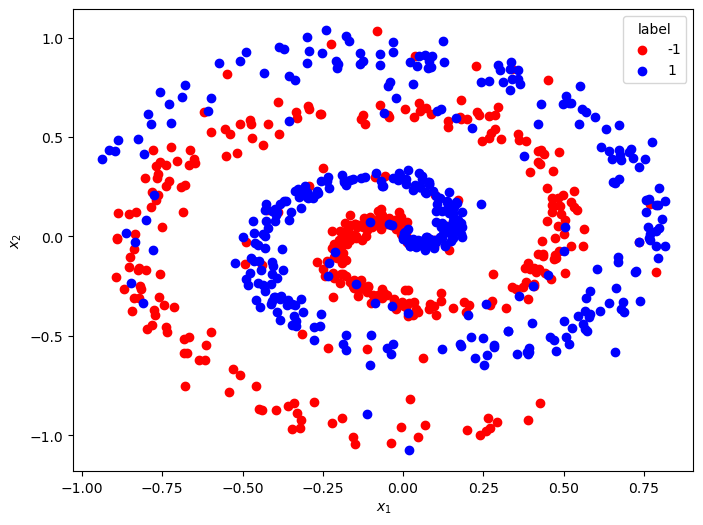

In [21]:
LABELS = [-1, 1]
SP_THETA_SIGMA = 0.3
SP_R_SIGMA = 0.05
NOISE_LEVEL = 0.2

m = 1000
Xsp, ysp = utils_hw4.generate_spiral_data(m, noise_level=NOISE_LEVEL, theta_sigma=SP_THETA_SIGMA, r_sigma=SP_R_SIGMA)
Xsp_train, ysp_train, Xsp_test, ysp_test = utils_hw4.create_split(Xsp, ysp, 0.8)
utils_hw4.scatter_plot(Xsp_train, ysp_train, labels=LABELS)  

In [22]:
spiral_perceptron_clf = PerceptronClassifier()
spiral_perceptron_clf.fit(Xsp_train, ysp_train)

print('Number of errors:', spiral_perceptron_clf.compute_num_errors())

KeyboardInterrupt: 

<span style="color: red">
<h4 style="font-weight: bold">[Answer Questions]</h4>

What happens when you run perceptron on spiral data? Why would it happen?<br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: The algorithm continues indefinitely. This is because the data is not linearly separable. 
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

To avoid the issue above, we need to manually set stopping rule. We will just restrict the number of epochs now but you are welcome to try other stopping rules. 

In [25]:
class PerceptronStoppingClassifier(PerceptronClassifier):
    def __init__(self, num_epochs=100):
        super().__init__()
        self.num_epochs = num_epochs

    def stopping_criterion(self, errors):
        return super().stopping_criterion(errors) or self.finished_epochs >= self.num_epochs

In [26]:
spiral_perceptron_stop_clf = PerceptronStoppingClassifier()
spiral_perceptron_stop_clf.fit(Xsp_train, ysp_train, Xsp_test, ysp_test)

report_losses(spiral_perceptron_stop_clf, Xsp_train, ysp_train, Xsp_test, ysp_test)

Training error (0-1 loss): 0.4625
Test error (0-1 loss): 0.4350
Training hinge loss: 0.9698
Test hinge loss: 0.9763
Training squared loss: 0.9695
Test squared loss: 0.9824


Finally, we will run perceptron with stopping rule on the SPAM dataset. 

Training error (0-1 loss): 0.1157
Test error (0-1 loss): 0.1283
Training hinge loss: 0.4049
Test hinge loss: 0.4121
Training squared loss: 465.0364
Test squared loss: 377.4020


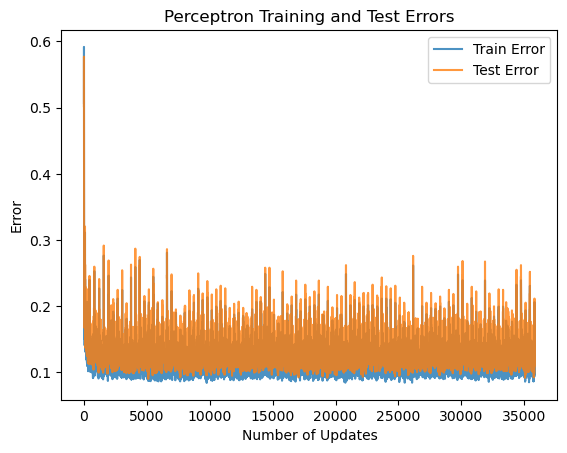

In [27]:
spam_perceptron_stop_clf = PerceptronStoppingClassifier()
spam_perceptron_stop_clf.fit(vectorized_data.X_train, vectorized_data.y_train, vectorized_data.X_test, vectorized_data.y_test)

report_losses(spam_perceptron_stop_clf, vectorized_data.X_train, vectorized_data.y_train, vectorized_data.X_test, vectorized_data.y_test)

train_errors, test_errors = spam_perceptron_stop_clf.get_error_traces()
utils_hw4.plot_errors(train_errors, test_errors)

### [Task 3] Linear Programming with Hinge Loss

In lecture 5 and tutorial we learned how to view minimizing the hinge loss $\sum_i [1-h_w(\phi(x_i)) y_i]_+$ as solving a linear programming problem. In this task, you need to provide each parameter for the `linprog` function, whose definitions are provided in https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html. 

In [29]:
from scipy.optimize import linprog

# Subclass for Hinge Loss Optimization (LP)
class HingeLossClassifier(LinearClassifier):
    def fit(self, X, y):
        """Fit using hinge loss optimization with linear programming."""
        # variable [w, xi] whose shape is n_feature+n_sample
        n_sample, n_feature = self.phi(X).shape

        # Define linear program parameters
        #### TASK 3 CODE
        # c appears in the objective function c @ [w,xi].
        c = np.concatenate([np.zeros(n_feature), np.ones(n_sample)]) #this is a vector of length n_feature+n_sample

        # A_ub and b_ub appears in the inequality constraint A_ub @ [w,xi] <= b_ub. 
        A_ub = np.hstack([-1 * y[:, np.newaxis] * self.phi(X), -1 * np.identity(n_sample)]) #this is a matrix of size n_sample x (n_feature+n_sample)
        b_ub =  -1 * np.ones(n_sample) #this is a vector of length n_sample

        # A_eq and b_eq appears in the equality constraint A_eq @ [w,xi] = b_eq. But there is no equality constraint in the hinge loss optimization so we don't need to define A_eq and b_eq.

        # bounds is a list of length n_feature+n_sample. Each element is a tuple with two numbers (min, max) that represent the lower and upper bounds of the corresponding variable. 
        # You can use None to indicate there is no bound. For instance, (0, None) means that the decision variable is non-negative, and the pair (None, None) means no bounds at all, i.e. all variables are allowed to be any real.
        bounds = [(None, None) for _ in range(n_feature)] + [(0, None) for _ in range(n_sample)]
        #### TASK 3 CODE

        # Solve linear program
        result = linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=bounds)
        if result.success:
            #### TASK 3 CODE
            # result.x contains the optimal values of [w,xi] and its dimension is n_feature+n_sample. We only want w.
            self.w = result.x[:n_feature]
            #### TASK 3 CODE
        else:
            raise ValueError("Linear program did not converge.")

spam_hinge_clf = HingeLossClassifier()
spam_hinge_clf.fit(vectorized_data.X_train, vectorized_data.y_train)


report_losses(spam_hinge_clf, vectorized_data.X_train, vectorized_data.y_train, vectorized_data.X_test, vectorized_data.y_test)



Training error (0-1 loss): 0.0724
Test error (0-1 loss): 0.0848
Training hinge loss: 0.1717
Test hinge loss: 0.1994
Training squared loss: 27.4355
Test squared loss: 26.4936


<span style="color: red">
<h4 style="font-weight: bold">[Answer Questions]</h4>

Please compare different losses of all the three methods we implemented for SPAM dataset. Which method gives the best 0-1 loss? Which method gives the best hinge loss? Which method gives the best squared loss? <br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: The linear programming method gives the best 0-1 loss, with square loss following, and the perceptron algorithm last. The linear programming method has the lowest hinge loss, with the perceptron following it, and the square loss last. The method that gives the best squared loss is the squared loss algorithm, followed by the perceptron algorithm, and last was the linear programming method.
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

### [Task 4 (Challenge-Optional)] Find the optimal linear predictor

Let's have some fun by competing with the class in a Kaggle competition!

We have implemented three different ways as alternatives to directly minimizing the 0-1 loss. Now you will keep using the same feature map for Spam but you can try other ways to train a linear predictor aiming to minimize the 0-1 loss. 

In addition to the Spam prediction data we provided, there's an additional held-out testing data split that we haven't released yet. This simulates a real-world scenario where you don't know about your testing data before actually testing your machine learning models. On our [Kaggle competition webpage](https://www.kaggle.com/t/047dbcce58314537bba2dbc25b5d73e2), you can access the testing data (without ground-truth labels, of course) and use the linear model you are most confident in to make predictions. After submitting your predictions, you'll see a score on the **public** leaderboard, representing the empirical error evaluated on the validation data (i.e., the test data we provided to you earlier). However, the **private** leaderboard, containing scores for the held-out testing data, is what truly matters. The results of the private leaderboard will be visible after the competition concludes.

In [ ]:
!wget  -O $PWD/data/SMSSpamCollection_test_text https://www.dropbox.com/scl/fi/cbwbxj862paf0bhbpmy9c/SMSSpamCollection_test_text?rlkey=7t7qrd2rawn8i7d8i1r54oum1&dl=1

In [ ]:
# Subclass for your linear classifier. 
class YourLinearClassifier(LinearClassifier):
    def fit(self, X, y):
        """Fit using least-squares linear regression."""
        #### TASK 4 code
        # Design a way to learn the weight vector self.w
        self.w = 
        #### TASK 4 code

In [ ]:
clf = YourLinearClassifier()
clf.fit(vectorized_data.X_train, vectorized_data.y_train)

In [ ]:
Xr, yr = utils_hw4.read_sms_spam_data(os.path.join(os.getcwd(), 'data/SMSSpamCollection'))
spamdata = TrainAndTestData(*utils_hw4.create_split(Xr, yr, 0.7))
vectorized_public_X = Vectorizer.vectorize(spamdata.X_test, d=100)
public_y = spamdata.y_test
private_X, private_y = utils_hw4.read_sms_spam_data(os.path.join(os.getcwd(), 'data/SMSSpamCollection_test_text'))
vectorized_private_X = Vectorizer.vectorize(private_X, d=100)
X = np.concatenate([vectorized_public_X, vectorized_private_X])
pred_y = clf.predict(X)

In [ ]:
with open('prediction.csv', 'w') as f:
    f.write('ID,LABEL\n')
    for i, y in enumerate(pred_y):
        f.write(f"{i},{str(y)}\n")